#Imports

In [ ]:
from datetime import datetime
from distutils.util import strtobool
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import boxcox, t
import scipy.stats as st

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [ ]:
np.exp(0.018)

1.0181629763897937

#Ingest Data

In [ ]:
# Converts the contents in a .tsf file into a dataframe and returns it along with other meta-data of the dataset: frequency, horizon, whether the dataset contains missing values and whether the series have equal lengths
#
# Parameters
# full_file_path_and_name - complete .tsf file path
# replace_missing_vals_with - a term to indicate the missing values in series in the returning dataframe
# value_column_name - Any name that is preferred to have as the name of the column containing series values in the returning dataframe
def convert_tsf_to_dataframe(
    full_file_path_and_name,
    replace_missing_vals_with="NaN",
    value_column_name="series_value",
):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )

In [ ]:
bitcoinData, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("/content/drive/MyDrive/CIVE7100/bitcoin_dataset_without_missing_values.tsf")

In [ ]:
def createTimeDF(rowIndex):

  dataLength = len(bitcoinData.series_value.iloc[rowIndex])
  startingDate = pd.to_datetime(bitcoinData.start_timestamp.iloc[rowIndex])
  dateIndex = pd.date_range(startingDate, periods = dataLength)
  seriesName = bitcoinData.series_name.iloc[rowIndex]

  newDF = pd.DataFrame({seriesName : bitcoinData.series_value.iloc[rowIndex]}).set_index(dateIndex)

  return newDF

In [ ]:
bitcoin = pd.DataFrame()

for i in range(len(bitcoinData)):

  tempDF = createTimeDF(i)
  bitcoin = bitcoin.join(tempDF, how = 'outer')

bitcoin.drop(['market_cap'], axis = 1, inplace = True)
bitcoin.dropna(inplace = True)

bitcoin.head()

,difficulty,sent_addresses,send_usd,confirmation_time,transactions,median_transaction_size,mining_profitability,fee_reward,top_100_percent,median_transaction_value,av_transaction_value,block_size,hashrate,active_addresses,google_trends,tweets,price
2014-04-09,6.119726e+09,122401.0,239212041.0,8.944,64992.0,0.0447,38.678,0.502,19.211,100.420,4115.0,243742.0,4.676242e+16,179274.0,11.193,8193.0,447.110
2014-04-10,6.119726e+09,124298.0,310367120.0,9.290,67872.0,0.0408,31.917,0.371,19.166,120.946,4876.0,254334.0,4.968287e+16,182996.0,13.854,15039.0,407.703
2014-04-11,6.119726e+09,117926.0,292756343.0,8.521,65563.0,0.0403,36.814,0.330,19.141,108.481,4819.0,223656.0,4.644150e+16,169622.0,12.997,14907.0,403.328
2014-04-12,6.119726e+09,87828.0,157264741.0,8.944,47579.0,0.0425,34.498,0.226,19.145,84.408,3574.0,169964.0,4.973440e+16,132283.0,9.229,7582.0,425.310
2014-04-13,6.119726e+09,94828.0,154756367.0,7.701,50981.0,0.0416,34.141,0.221,19.131,69.681,3332.0,162260.0,5.707190e+16,172708.0,10.385,10674.0,415.876


In [ ]:
bitcoin.to_csv("/content/drive/MyDrive/CIVE7100/bitcoinData.csv")

# Import cleaned CSV

In [ ]:
bitcoin = pd.read_csv("/content/drive/MyDrive/CIVE7100/bitcoinData.csv")

#Univariate EDA

Text(0.5, 1.0, 'Bitcoin Pricing (2010-2021) Histogram')

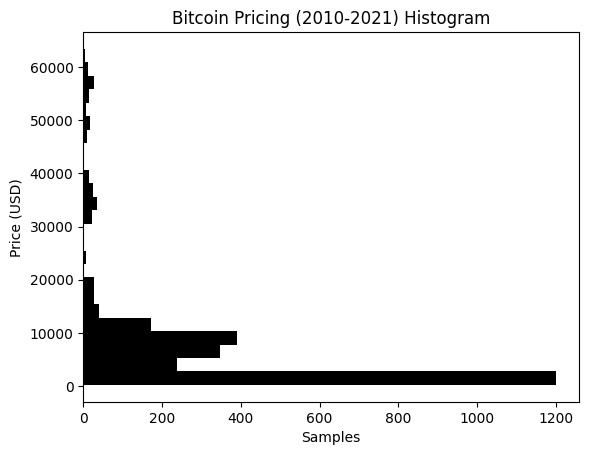

In [ ]:
plt.hist(bitcoin.price, bins = 25, orientation = 'horizontal', color = 'black')
plt.ylabel("Price (USD)")
plt.xlabel("Samples")
plt.title("Bitcoin Pricing (2010-2021) Histogram")

Text(0.5, 1.0, 'Daily Closing Price of Bitcoin')

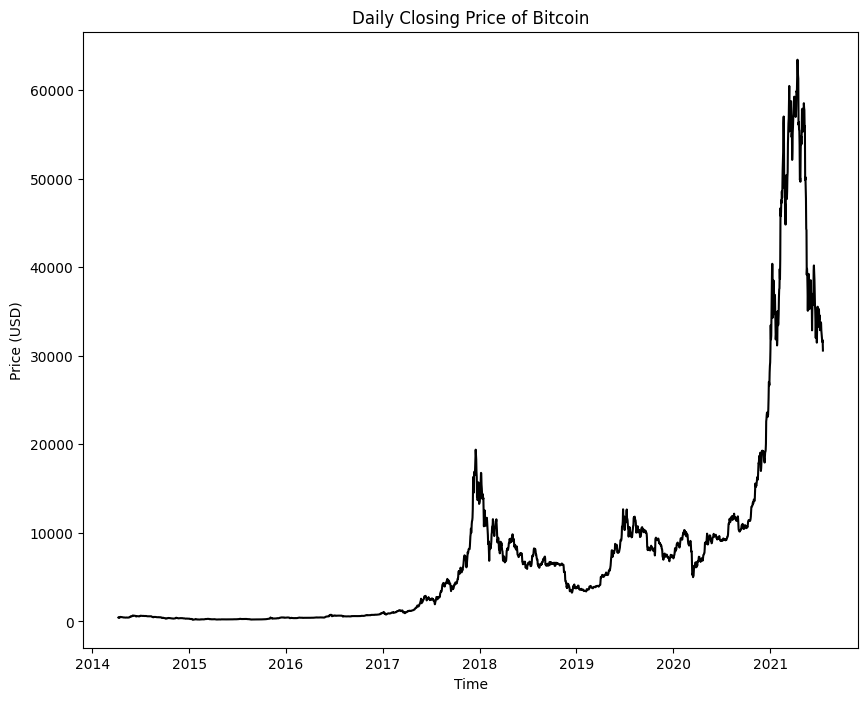

In [ ]:
plt.figure(figsize = (10, 8))
plt.plot(bitcoin.index, bitcoin.price, color = 'black')
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Daily Closing Price of Bitcoin")

In [ ]:
plt.figure(figsize = (10, 8))
plt.plot(bitcoin.index, bitcoin.price, color = 'black')
#plt.xlim(pd.Timestamp('2013-07-01'), bitcoin.index[-1])
plt.xticks(rotation = 45)
plt.axvline(pd.Timestamp('2019-11-01'), color = 'darkblue', alpha = 0.5, linestyle = 'dashed', label = 'COVID Lockdowns Begin')
plt.axvline(pd.Timestamp('2021-01-08'), color = 'red', alpha = 0.5, linestyle = 'dashed', label = 'Meme Stock Frenzy')
plt.axvspan(pd.Timestamp('2015-11-15'), pd.Timestamp('2018-08-11'), color = 'lightcoral', alpha = 0.5, label = 'Uras 2020 - LR & MLP & LSTM')
plt.axvspan(pd.Timestamp('2010-07-18'), pd.Timestamp('2018-03-31'), color = 'lightblue', alpha = 0.5)
plt.axvspan(pd.Timestamp('2013-04-01'), pd.Timestamp('2019-12-31'), color = 'darkgray', alpha = 0.5, label = 'Mudassir 2020 - SVM & LSTM')
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Daily Closing Price of Bitcoin")
plt.legend()


In [ ]:
corrmat = bitcoin.corr()

plt.figure(figsize=(13, 6))
sns.heatmap(corrmat, vmax=1, annot=True, linewidths=.5)
plt.xticks(rotation=30, horizontalalignment='right')
plt.title("Bitcoin Variable Correlation Heatmap")
plt.show()

# Transform to log returns

In [ ]:
bitcoin['logReturn'] = np.log(bitcoin['price'].astype('float64')/bitcoin['price'].astype('float64').shift(1))
bitcoin.dropna(inplace = True)
bitcoin.head()

,difficulty,sent_addresses,send_usd,confirmation_time,transactions,median_transaction_size,mining_profitability,fee_reward,top_100_percent,median_transaction_value,av_transaction_value,block_size,hashrate,active_addresses,google_trends,tweets,price,logReturn
2014-04-10,6.119726e+09,124298.0,310367120.0,9.290,67872.0,0.0408,31.917,0.371,19.166,120.946,4876.0,254334.0,4.968287e+16,182996.0,13.854,15039.0,407.703,-0.092266
2014-04-11,6.119726e+09,117926.0,292756343.0,8.521,65563.0,0.0403,36.814,0.330,19.141,108.481,4819.0,223656.0,4.644150e+16,169622.0,12.997,14907.0,403.328,-0.010789
2014-04-12,6.119726e+09,87828.0,157264741.0,8.944,47579.0,0.0425,34.498,0.226,19.145,84.408,3574.0,169964.0,4.973440e+16,132283.0,9.229,7582.0,425.310,0.053068
2014-04-13,6.119726e+09,94828.0,154756367.0,7.701,50981.0,0.0416,34.141,0.221,19.131,69.681,3332.0,162260.0,5.707190e+16,172708.0,10.385,10674.0,415.876,-0.022431
2014-04-14,6.119726e+09,127969.0,253143718.0,7.461,70026.0,0.0446,37.973,0.318,19.146,115.249,3990.0,216048.0,5.683809e+16,183291.0,10.754,13266.0,445.898,0.069703


Text(0.5, 1.0, 'Log Returns for Bitcoin Pricing')

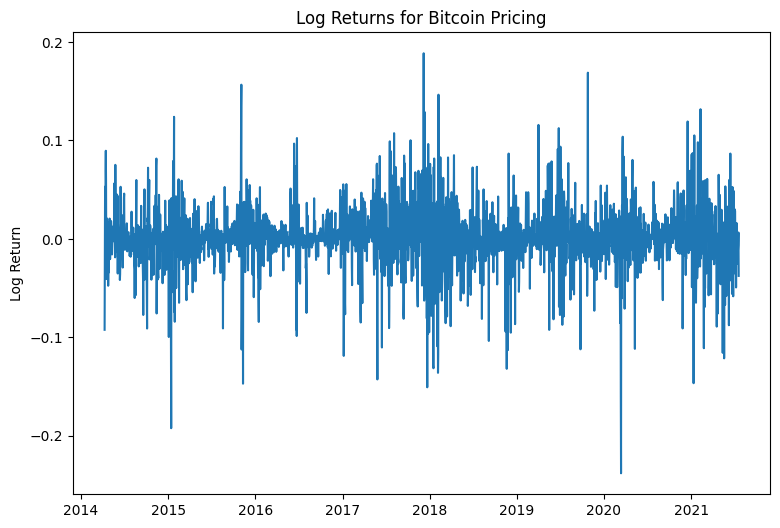

In [ ]:
plt.figure(figsize = (9, 6))
plt.plot(bitcoin.index, bitcoin.logReturn)
plt.ylabel("Log Return")
plt.title("Log Returns for Bitcoin Pricing")

Text(0.5, 9.444444444444438, 'Log Returns')

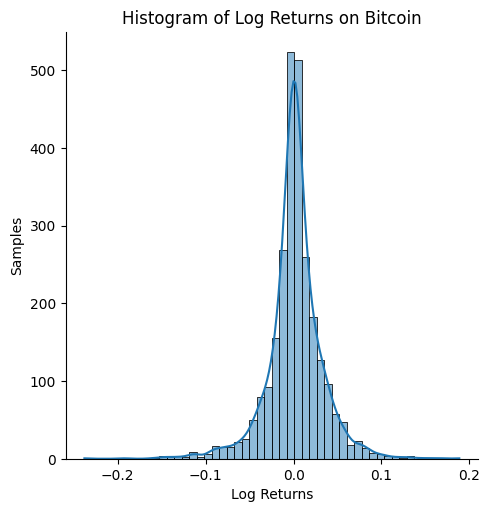

In [ ]:
sns.displot(bitcoin.logReturn, kde = True, bins = 50)
plt.title("Histogram of Log Returns on Bitcoin")
plt.ylabel("Samples")
plt.xlabel("Log Returns")

In [ ]:
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "t", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("\nBest fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

get_best_distribution(bitcoin.logReturn)

p value for norm = 7.153053425242435e-27
p value for exponweib = 1.917884199909768e-22
p value for weibull_max = 8.163710367708718e-44
p value for t = 0.0275979310650325
p value for weibull_min = 1.1639222923438624e-35
p value for pareto = 0.0
p value for genextreme = 7.727188256400171e-44

Best fitting distribution: t
Best p value: 0.0275979310650325
Parameters for the best fit: (2.1289887377515866, 0.0017634935023434506, 0.016779048096679197)


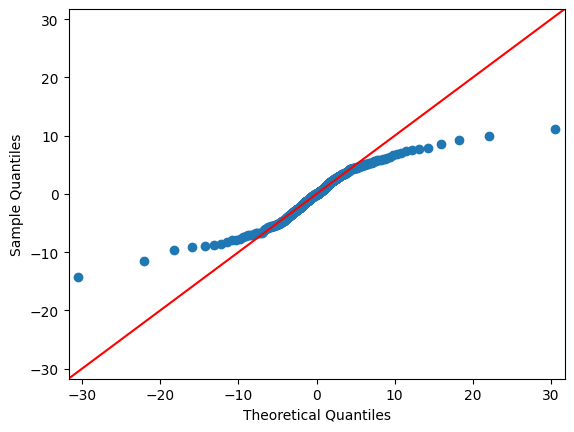

In [ ]:
sm.qqplot(bitcoin.logReturn, st.t, fit = True, line = '45')
plt.show()

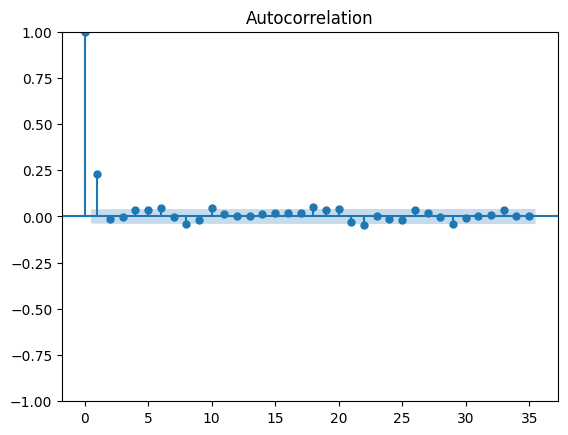

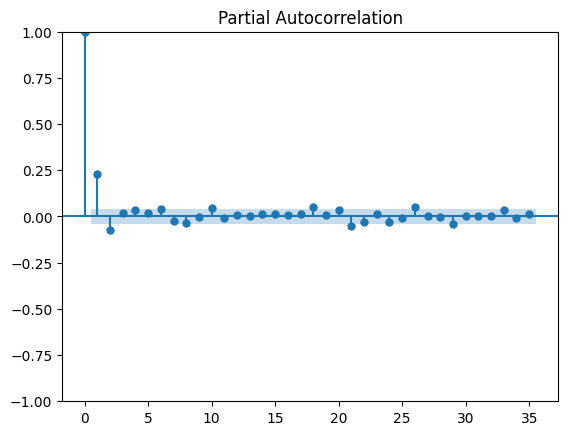

In [ ]:
plot_acf(bitcoin.logReturn)
plot_pacf(bitcoin.logReturn)
plt.show()

AR(2) probably fits best with logged returns.

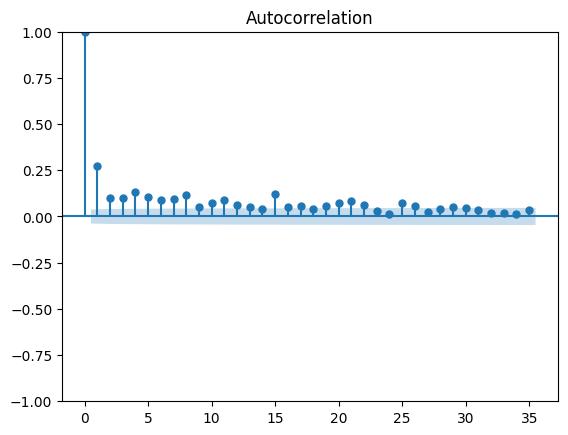

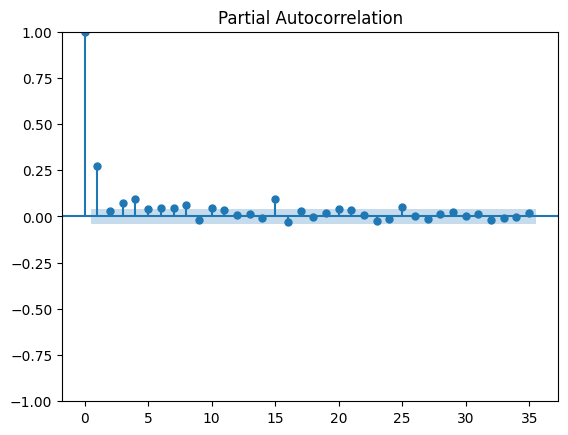

In [ ]:
plot_acf(bitcoin.logReturn ** 2)
plot_pacf(bitcoin.logReturn ** 2)
plt.show()

Squared logged returns may say otherwise for Autocorrelation; however, PACF still suggests AR(1)

#Quantify Trend Stationarity

In [ ]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

adf_test(bitcoin.logReturn)

Results of Dickey-Fuller Test:
Test Statistic                -1.520871e+01
p-value                        5.694417e-28
#Lags Used                     9.000000e+00
Number of Observations Used    2.648000e+03
Critical Value (1%)           -3.432822e+00
Critical Value (5%)           -2.862632e+00
Critical Value (10%)          -2.567351e+00
dtype: float64


Found to be *trend* stationary, but we know it's not variance stationary.

# Feature Reduction

In [ ]:
fs = SelectKBest(score_func = mutual_info_regression, k = 10)
# learn relationship from training data
fs.fit(bitcoin.drop(['logReturn', 'price'], axis = 1), bitcoin.logReturn)
fs.get_feature_names_out()

array(['difficulty', 'send_usd', 'median_transaction_size', 'fee_reward',
       'top_100_percent', 'block_size', 'hashrate', 'active_addresses',
       'google_trends', 'tweets'], dtype=object)

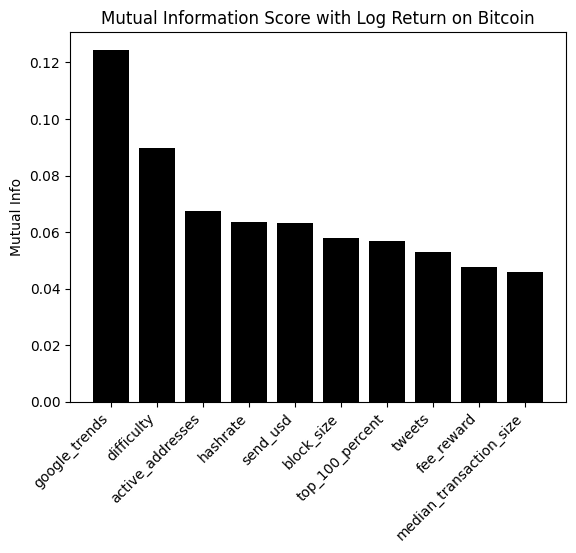

In [ ]:
# Get the indices sorted by most important to least important
indices = np.argsort(fs.scores_)[::-1]

# To get your top 10 feature names
features = []
for i in range(10):
    features.append(bitcoin.drop(['logReturn'], axis = 1).columns[indices[i]])

# Now plot
plt.figure()
plt.bar(features, fs.scores_[indices[range(10)]], color='black', align='center')
plt.title("Mutual Information Score with Log Return on Bitcoin")
plt.ylabel('Mutual Info')
plt.xticks(rotation = 45, ha = 'right')
plt.show()

Only use google trends, difficulty, and active addresses going forward. May need to normalize or transform somehow going forward.

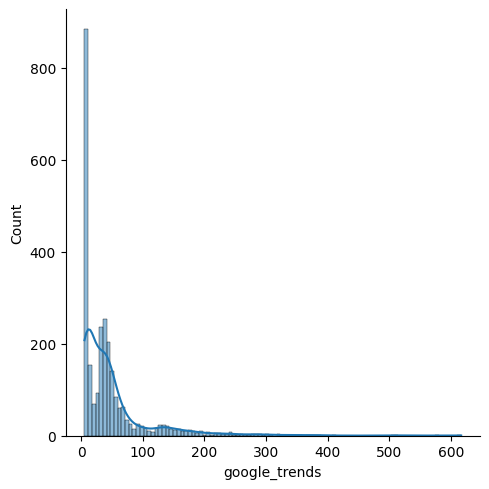

In [ ]:
sns.displot(bitcoin.google_trends, kde = True)

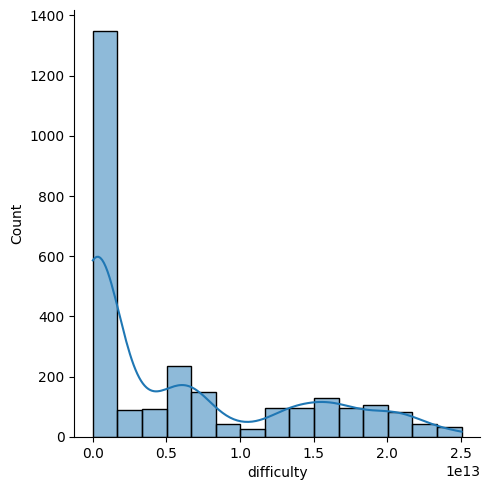

In [ ]:
sns.displot(bitcoin.difficulty, kde = True)

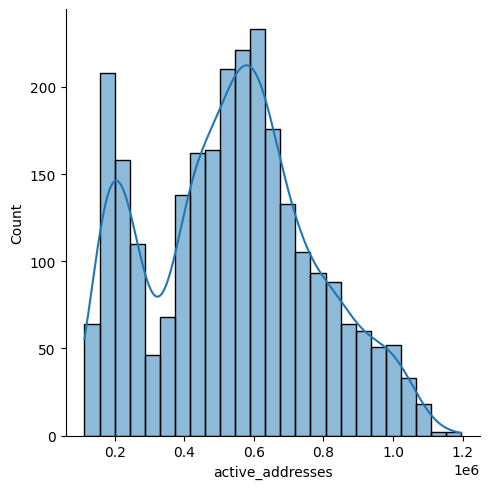

In [ ]:
sns.displot(bitcoin.active_addresses, kde = True)

#Test Train Split for Future Models

Last 7 days as testing days

In [ ]:
trainBitcoin = bitcoin[['google_trends', 'difficulty', 'active_addresses', 'logReturn']][:-7]
testBitcoin = bitcoin[['google_trends', 'difficulty', 'active_addresses', 'logReturn']][-7:]

In [ ]:
trainBitcoin.to_csv("/content/drive/MyDrive/CIVE7100/trainBitcoin.csv")
testBitcoin.to_csv("/content/drive/MyDrive/CIVE7100/testBitcoin.csv")